In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

# Configuration
IMG_SIZE = (128, 128)  # Resize images to 128x128
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
df = pd.read_csv("CNN.csv")

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Image transformation pipeline
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Convert to tensor and normalize [0,1]
])

# Custom dataset class
class WVREstimationDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # Image filename
        img = Image.open(img_name).convert("RGB")  # Open image
        if self.transform:
            img = self.transform(img)
        wvr = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.float32)  # WVR value
        return img, wvr

# Create datasets
train_dataset = WVREstimationDataset(train_df, transform)
test_dataset = WVREstimationDataset(test_df, transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),  # Adjust based on input size
            nn.ReLU(),
            nn.Linear(128, 1)  # Output single WVR value
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model
model = CNNModel().to(DEVICE)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for images, wvr_values in train_loader:
        images, wvr_values = images.to(DEVICE), wvr_values.to(DEVICE).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, wvr_values)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss/len(train_loader):.4f}")

# Function to predict WVR for a new image
def predict_wvr(image_path, model):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension

    with torch.no_grad():
        prediction = model(image).item()
    
    return prediction

# Example usage
image_path = "test_image.png"
predicted_wvr = predict_wvr(image_path, model)
print(f"Predicted WVR value: {predicted_wvr:.4f}")


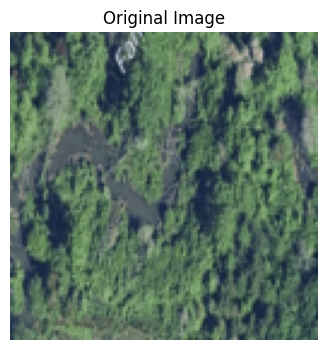

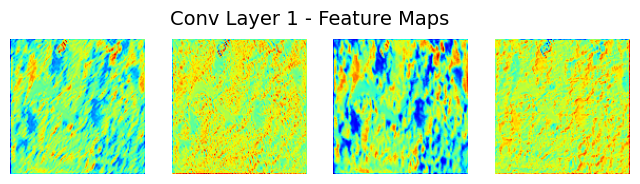

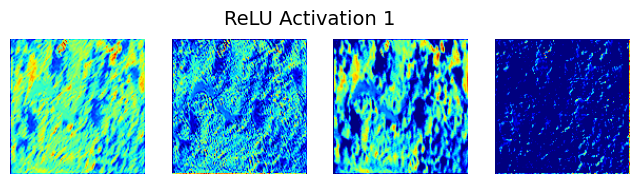

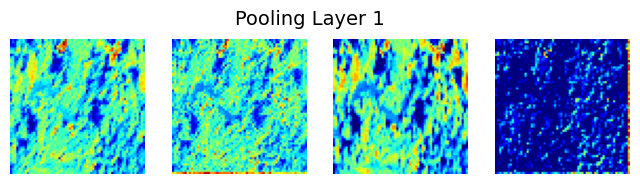

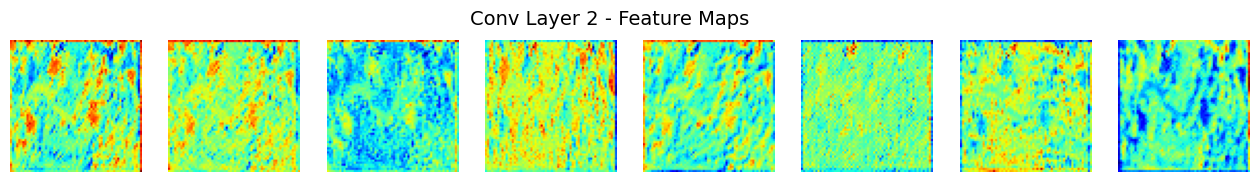

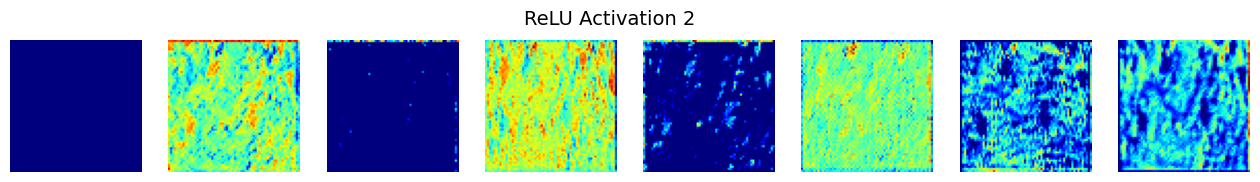

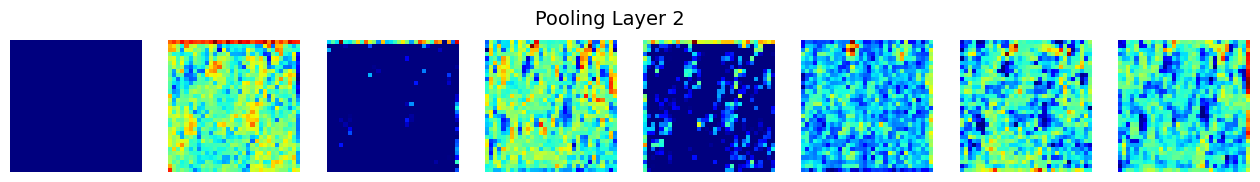

In [9]:
#Visualization
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load and preprocess the image
image_path = "image2.png"  # Replace with actual image
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize for CNN input
    transforms.ToTensor()  # Convert to tensor (RGB image with 3 channels)
])

image = Image.open(image_path).convert("RGB")
image = transform(image).unsqueeze(0)  # Add batch dimension

# Define a simple CNN model with visualization in mind
class CNNVisualizer(nn.Module):
    def __init__(self):
        super(CNNVisualizer, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, padding=1)  # 3 channels for RGB input, 4 feature maps
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # Pooling layer

        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1)  # 8 feature maps
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # Pooling layer

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(8 * 32 * 32, 1)  # Fully connected layer

    def forward(self, x):
        conv1_out = self.conv1(x)
        relu1_out = self.relu1(conv1_out)
        pool1_out = self.pool1(relu1_out)

        conv2_out = self.conv2(pool1_out)
        relu2_out = self.relu2(conv2_out)
        pool2_out = self.pool2(relu2_out)

        return conv1_out, relu1_out, pool1_out, conv2_out, relu2_out, pool2_out

# Initialize model and get outputs
model = CNNVisualizer()
conv1_out, relu1_out, pool1_out, conv2_out, relu2_out, pool2_out = model(image)

# Function to visualize feature maps
def visualize_feature_maps(feature_maps, title):
    feature_maps = feature_maps.squeeze(0).detach().numpy()  # Remove batch dimension
    num_maps = feature_maps.shape[0]

    fig, axes = plt.subplots(1, num_maps, figsize=(num_maps * 2, 2))
    fig.suptitle(title, fontsize=14)

    for i in range(num_maps):
        axes[i].imshow(feature_maps[i], cmap="jet")  # Using 'jet' colormap for color scale
        axes[i].axis("off")

    plt.show()

# Visualize steps of CNN processing
plt.figure(figsize=(4, 4))
plt.imshow(image.squeeze(0).permute(1, 2, 0))  # Convert the tensor back to an image
plt.title("Original Image")
plt.axis("off")
plt.show()

visualize_feature_maps(conv1_out, "Conv Layer 1 - Feature Maps")
visualize_feature_maps(relu1_out, "ReLU Activation 1")
visualize_feature_maps(pool1_out, "Pooling Layer 1")

visualize_feature_maps(conv2_out, "Conv Layer 2 - Feature Maps")
visualize_feature_maps(relu2_out, "ReLU Activation 2")
visualize_feature_maps(pool2_out, "Pooling Layer 2")


In [3]:
# Function to predict WVR for a new image
def predict_wvr(image_path, model):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension

    with torch.no_grad():
        prediction = model(image).item()
    
    return prediction

# Example usage
image_path = "test_image.png"
predicted_wvr = predict_wvr(image_path, model)
print(f"Predicted WVR value: {predicted_wvr:.4f}")

Predicted WVR value: 0.1415
